# Phase 3 Data Science Training Notebook

In [1]:
from data_processing import *
import tarfile
import pickle
from matplotlib import pyplot as plt

## Exploratory Data Analysis

In [2]:
# extract data from .tar.gz file
file = tarfile.open('cifar-10-python.tar.gz')
file.extractall('./')
file.close()

In [3]:
# extract meta data from meta file
meta_data = unpickle("cifar-10-batches-py/batches.meta")
print(meta_data)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [4]:
# extract label names from meta data
label_names = meta_data[b'label_names']

In [5]:
# load training and test batches
train_batches, test_batch = load_batches()

In [6]:
# see keys in batch
print(test_batch.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [7]:
# shape of each batch
for batch in [*train_batches, test_batch]:
    for key, value in batch.items():
        if key == b'batch_label':
            print(value)
        else:
            print(f'Shape of {key}: {np.shape(value)}')
    print('')

b'training batch 1 of 5'
Shape of b'labels': (10000,)
Shape of b'data': (10000, 3072)
Shape of b'filenames': (10000,)

b'training batch 2 of 5'
Shape of b'labels': (10000,)
Shape of b'data': (10000, 3072)
Shape of b'filenames': (10000,)

b'training batch 3 of 5'
Shape of b'labels': (10000,)
Shape of b'data': (10000, 3072)
Shape of b'filenames': (10000,)

b'training batch 4 of 5'
Shape of b'labels': (10000,)
Shape of b'data': (10000, 3072)
Shape of b'filenames': (10000,)

b'training batch 5 of 5'
Shape of b'labels': (10000,)
Shape of b'data': (10000, 3072)
Shape of b'filenames': (10000,)

b'testing batch 1 of 1'
Shape of b'labels': (10000,)
Shape of b'data': (10000, 3072)
Shape of b'filenames': (10000,)



In [8]:
# function to return data with chosen label
def filter_by_label(batch, label, max):
    filtered = []
    count = 0
    i = 0
    while count < max:
        if batch[b'labels'][i] == label:
            filtered.append(batch[b'data'][i])
            count += 1
        i += 1
    return filtered


C:\Users\Angela (school)\AppData\Local\Temp\ipykernel_26296\1209438573.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


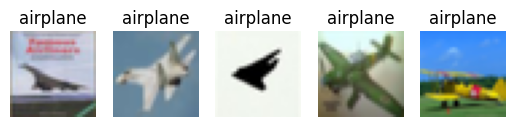

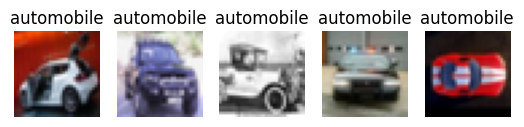

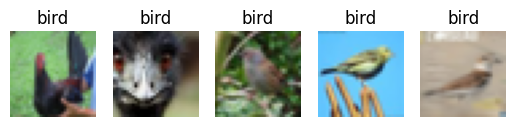

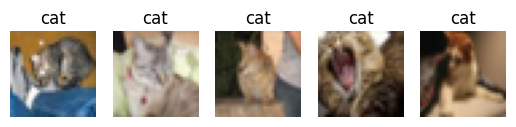

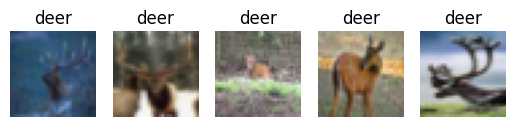

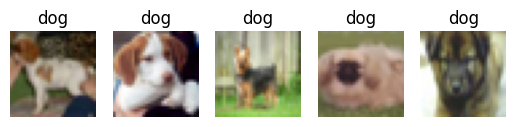

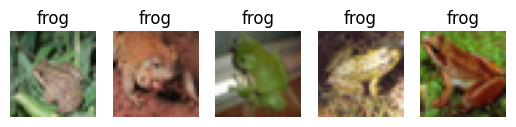

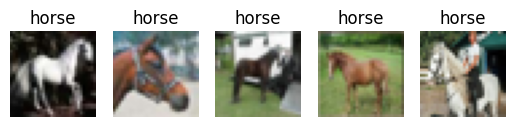

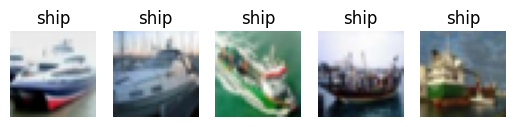

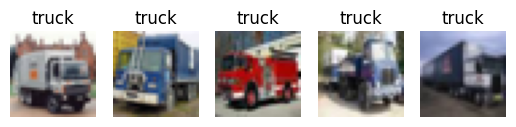

In [9]:
# loop through each label
for i, label in enumerate(label_names):
    # show first five images with label
    fig, axs = plt.subplots(ncols=5)
    for j, data in enumerate(filter_by_label(test_batch, i, 5)):
        show_image(axs[j], reshape_image(data))
        axs[j].set_title(label.decode('ascii'))
    fig.show()

# Data Processing

In [10]:
# choose airplanes label (0)
train_x, train_y = process_batch(combine_batches(train_batches), 0, 5000)
test_x, test_y = process_batch(test_batch, 0, 1000)

In [11]:
# check training set is balanced
np.unique(train_y, return_counts=True)

(array([0, 1]), array([5000, 5000], dtype=int64))

In [12]:
# check test set is balanced
np.unique(test_y, return_counts=True)

(array([0, 1]), array([1000, 1000], dtype=int64))

# Data Modelling

In [13]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime

In [18]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal",
        input_shape=(32,32,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
    )

    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32,32,3,))) # Input layer.

    model.add(data_augmentation)
    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(84, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(2))

    model.compile(
        optimizer='adam',
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [19]:
model = generateModel()

date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

log_dir = "output/logs/" + date

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=500,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    verbose=0 # Uncomment this line to reduce the printing on console.
)

In [20]:
model.evaluate(test_x, test_y)

63/63 [==============================] - 1s 14ms/step - loss: 0.2409 - accuracy: 0.9135


[0.24094673991203308, 0.9135000109672546]

In [21]:
model.save('output/final_model')

INFO:tensorflow:Assets written to: output/final_model\assets


INFO:tensorflow:Assets written to: output/final_model\assets
